### "Шапка" с названием проекта

В этой ячейке вы найдете оглавление и ключевые этапы работы, которые помогут вам ориентироваться в процессе выполнения проекта. Проект разделен на пять основных этапов, четыре из которых (этапы 2, 3, 4 и 5) вам предлагается выполнить в этом Jupyter Notebook:

- Подготовка среды MLflow - Первый шаг, подготовка и запуск сервисов MLflow, был выполнен вне ноутбука и оформлен в виде shell скрипта. Это основа для работы с экспериментами и логирования результатов ваших моделей.

- Этап 2 - Исследовательский Анализ Данных (EDA): На этом этапе вы проведете тщательный анализ данных, чтобы лучше понять их структуру и особенности.

- Этап 3 - Генерация Признаков и Обучение Модели: После анализа данных вы сгенерируете новые признаки и обучите модель, используя эти признаки.

- Этап 4 - Отбор Признаков и Обучение Модели: На этом шаге вы отберете наиболее значимые признаки и снова обучите модель для улучшения ее качества.

- Этап 5 - Подбор Гиперпараметров и Обучение Финальной Версии Модели: Финальный этап проекта посвящен оптимизации гиперпараметров для достижения максимального качества модели.

Для удобства навигации и организации работы, пожалуйста, следуйте оглавлению и рекомендациям, описанным в каждом этапе.

> ### Важно: Переобучение моделей
> На каждом этапе проекта, где требуется переобучение модели, важно не просто выполнить эту процедуру, но и тщательно проверить качество модели на соответствующих выборках. Это включает в себя анализ метрик качества, визуализацию результатов, сравнение с предыдущими моделями и, при необходимости, корректировку.

> ### Важно: Разделение выборок
> Перед началом выполнения вашего проекта важно правильно подготовить данные, разделив их на подвыборки. Это позволит оценить производительность модели более объективно и управлять риском переобучения. В зависимости от ваших целей и доступных данных, вы можете использовать различные стратегии разделения:

1. Разделение на train/val/test: Это классический подход, где данные делятся на три части. Обучающая выборка (train) используется для первичного обучения моделей, валидационная (val) - для настройки гиперпараметров и выбора лучшей модели, а тестовая (test) - для финальной оценки производительности модели. Такой подход идеален, если у вас достаточно данных, чтобы разделить их и каждая из выборок была репрезентативна.

2. Разделение на train/test с кросс-валидацией на train: Если данных недостаточно для трех подвыборок, можно ограничиться разделением на обучающую и тестовую выборки. В этом случае кросс-валидация на обучающей выборке поможет оценить стабильность модели и подобрать гиперпараметры.

Определение способа разделения данных: Выбор метода разбиения данных на подвыборки — train, validation и test — должен быть обоснован особенностями вашего набора данных и задачами проекта. Возможные методы разделения, включая различные стратегии и правила, подробно описаны в [документации scikit-learn по разбиению данных](https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html#sphx-glr-auto-examples-model-selection-plot-cv-indices-py). Вы можете следовать этим примерам или разработать собственный метод, исходя из специфики ваших данных.

Ваша задача - выбрать подходящий метод разделения данных исходя из объема и специфики ваших данных. Помните, что финальные метрики качества модели мы будем оценивать на тестовой выборке. Промежуточные результаты после каждого этапа проекта (например, после настройки гиперпараметров) следует оценивать на валидационной выборке, если таковая имеется. Это поможет вам корректно настроить модель перед финальной оценкой её производительности.

In [1]:
# сделайте разделение изначального набора данных в этой ячейке
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
import os
from autofeat import AutoFeatRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from category_encoders import CatBoostEncoder
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures, KBinsDiscretizer
from sklearn.model_selection import StratifiedKFold, cross_validate
from catboost import CatBoostRegressor
import warnings

warnings.filterwarnings("ignore")



ASSETS_DIR = "assets"
FS_ASSETS_DI = 'assets_fs'
os.makedirs(ASSETS_DIR, exist_ok=True)
os.makedirs(FS_ASSETS_DI, exist_ok=True)

seed = 42

df = pd.read_csv('initial_data.csv')
df['building_type_int'] = df['building_type_int'].astype('str')
X_train, X_test, y_train, y_test = train_test_split(df.drop('price',axis=1), df['price'], test_size=0.2, random_state=seed)


In [2]:
TRACKING_SERVER_HOST = "127.0.0.1"
TRACKING_SERVER_PORT = 5000


mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")
mlflow.set_registry_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")


#### Этап 2: Исследовательский Анализ Данных (EDA)
На этом этапе ваша задача - провести тщательный исследовательский анализ данных (EDA), чтобы глубже понять особенности и связи в предоставленном наборе данных. В процессе EDA вы должны обратить внимание на три ключевых аспекта, о которых мы говорили в теме 3 курса. Очень важно, чтобы все результаты вашего исследования, включая визуализации, статистический анализ и предварительные выводы, были аккуратно залогированы в MLflow.

Для более организованного исследования предлагаем следующие рекомендуемые шаги:
- Понимание данных: Первоначально ознакомьтесь с данными, изучите типы данных, проверьте наличие пропущенных значений.
- Визуализация данных: Используйте графики и диаграммы для визуализации распределений признаков и возможных взаимосвязей между ними.
- Статистический анализ: Примените статистические методы для изучения центральных тенденций, разброса и корреляций между признаками.
- Предварительные выводы: На основе проведённого анализа сформулируйте предварительные выводы о данных, которые помогут в дальнейшем этапе моделирования.

Помните, что EDA - это итеративный процесс, в котором вы можете возвращаться к предыдущим шагам для дополнительного анализа, если это будет необходимо. Все находки и выводы должны быть чётко зафиксированы и легко доступны для команды проекта.


In [3]:
# 2.1 Загрузка данных

In [4]:
df = df.reset_index()

In [5]:
df.head()

,index,building_id,floor,kitchen_area,living_area,rooms,is_apartment,studio,total_area,price,build_year,building_type_int,latitude,longitude,ceiling_height,flats_count,floors_total,has_elevator
0,0,22315,4,7.8,17.6,1,False,False,34.299999,5350000.0,2013,2,55.504986,37.534801,2.70,660,17,True
1,1,24504,12,16.0,32.0,2,False,False,56.900002,9690000.0,2020,2,55.572639,37.485806,2.85,227,12,True
2,2,23303,3,12.4,33.0,2,False,False,53.799999,9200000.0,2016,2,55.573334,37.490517,3.00,264,12,True
3,3,22328,8,15.0,42.0,3,False,False,75.599998,12500000.0,2013,2,55.572762,37.483112,2.80,455,17,True
4,4,22288,1,11.0,25.0,1,False,False,41.000000,6300000.0,2013,1,55.567425,37.475487,2.80,245,12,True


In [6]:
# 2.2. Общий обзор датасета

In [7]:
df.isna().sum()

index                0
building_id          0
floor                0
kitchen_area         0
living_area          0
rooms                0
is_apartment         0
studio               0
total_area           0
price                0
build_year           0
building_type_int    0
latitude             0
longitude            0
ceiling_height       0
flats_count          0
floors_total         0
has_elevator         0
dtype: int64

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104095 entries, 0 to 104094
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   index              104095 non-null  int64  
 1   building_id        104095 non-null  int64  
 2   floor              104095 non-null  int64  
 3   kitchen_area       104095 non-null  float64
 4   living_area        104095 non-null  float64
 5   rooms              104095 non-null  int64  
 6   is_apartment       104095 non-null  bool   
 7   studio             104095 non-null  bool   
 8   total_area         104095 non-null  float64
 9   price              104095 non-null  float64
 10  build_year         104095 non-null  int64  
 11  building_type_int  104095 non-null  object 
 12  latitude           104095 non-null  float64
 13  longitude          104095 non-null  float64
 14  ceiling_height     104095 non-null  float64
 15  flats_count        104095 non-null  int64  
 16  fl

In [9]:
df.describe()

,index,building_id,floor,kitchen_area,living_area,rooms,total_area,price,build_year,latitude,longitude,ceiling_height,flats_count,floors_total
count,104095.000000,104095.000000,104095.000000,104095.000000,104095.000000,104095.000000,104095.000000,1.040950e+05,104095.000000,104095.000000,104095.000000,104095.000000,104095.000000,104095.000000
mean,52047.000000,13504.084596,7.032855,8.378249,27.595582,1.948499,52.074677,1.192439e+07,1985.117710,55.726589,37.600759,2.692437,243.147951,13.327509
std,30049.782473,6520.896811,4.914407,3.536494,14.506247,0.814888,16.527051,4.580951e+06,19.751087,0.104199,0.149270,0.133727,170.087483,5.311246
min,0.000000,4.000000,1.000000,0.000000,0.000000,1.000000,11.000000,1.100000e+01,1902.000000,55.427238,37.190201,2.450000,1.000000,1.000000
25%,26023.500000,8390.000000,3.000000,6.100000,19.000000,1.000000,38.500000,8.600000e+06,1969.000000,55.646149,37.493713,2.640000,117.000000,9.000000
50%,52047.000000,13269.000000,6.000000,8.500000,28.500000,2.000000,49.700001,1.099000e+07,1981.000000,55.715603,37.589050,2.640000,203.000000,12.000000
75%,78070.500000,19046.000000,10.000000,10.000000,36.000000,3.000000,61.400002,1.420000e+07,2003.000000,55.813389,37.718697,2.740000,320.000000,17.000000
max,104094.000000,24620.000000,29.000000,102.000000,74.000000,7.000000,118.500000,2.840000e+07,2023.000000,56.011032,37.946411,3.000000,4455.000000,29.000000


In [10]:
df.nunique()

index                104095
building_id           20885
floor                    28
kitchen_area            734
living_area            1408
rooms                     6
is_apartment              2
studio                    1
total_area             1838
price                  4097
build_year              115
building_type_int         7
latitude              14471
longitude             14112
ceiling_height           35
flats_count             693
floors_total             29
has_elevator              2
dtype: int64

In [11]:
# 2.3 Анализ признаков для модели

2025-02-25 13:40:33,562 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-02-25 13:40:33,570 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


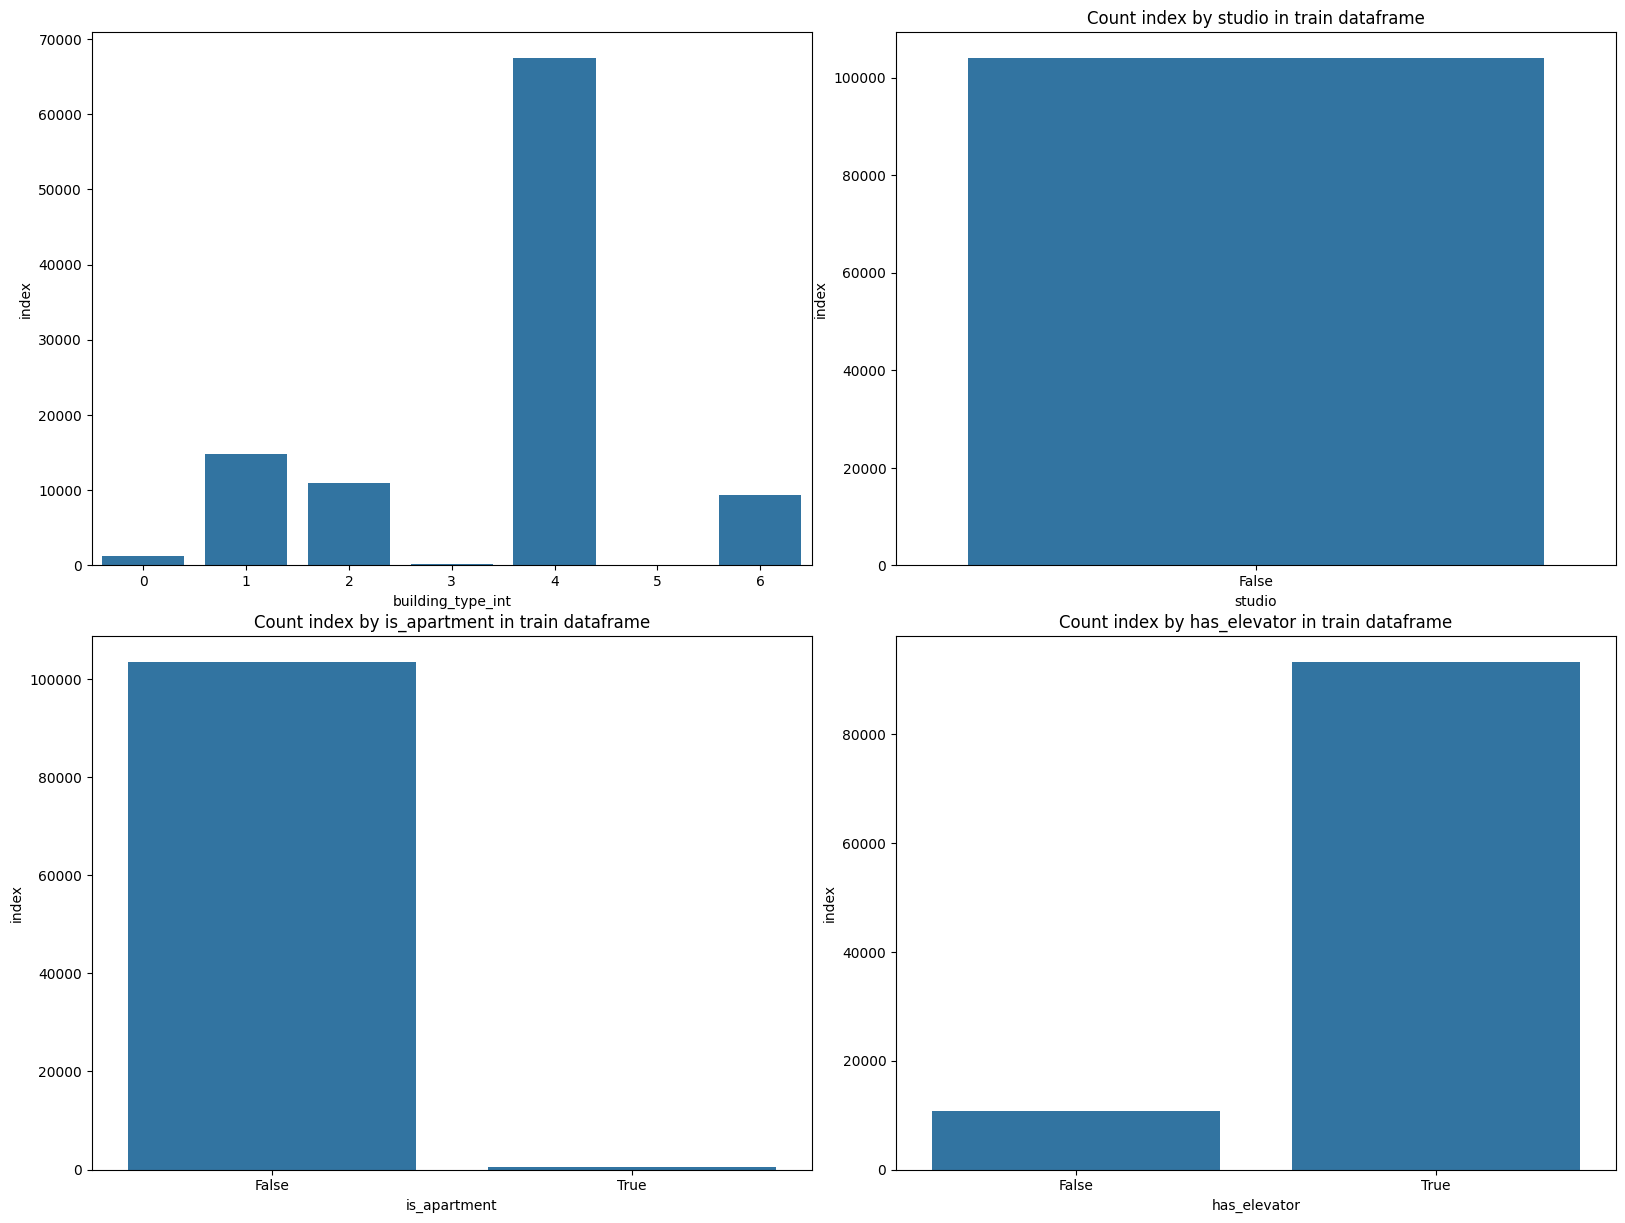

In [12]:
fig, axs = plt.subplots(2, 2)
fig.set_size_inches(16.5, 12.5, forward=True)
fig.tight_layout(pad=3)


x = "building_type_int"
y = "index"
stat = ["count"]
agg_df = df.groupby(x)[y].nunique().reset_index()
sns.barplot(data=agg_df, x=x, y=y, ax=axs[0, 0])


x = "studio"
y = "index"
# ваш код тут #
agg_df = df.groupby(x)[y].nunique().reset_index()
sns.barplot(data=agg_df, x=x, y=y, ax=axs[0, 1])
axs[0, 1].set_title(f'Count {y} by {x} in train dataframe')

x = "is_apartment"
y = "index"
# ваш код тут #
agg_df = df.groupby(x)[y].nunique().reset_index()
sns.barplot(data=agg_df, x=x, y=y, ax=axs[1, 0])
axs[1, 0].set_title(f'Count {y} by {x} in train dataframe')

x = "has_elevator"
y = "index"
# ваш код тут #
agg_df = df.groupby(x)[y].nunique().reset_index()
sns.barplot(data=agg_df, x=x, y=y, ax=axs[1, 1])
axs[1, 1].set_title(f'Count {y} by {x} in train dataframe')

plt.savefig(os.path.join(ASSETS_DIR, 'cat_features_1'))

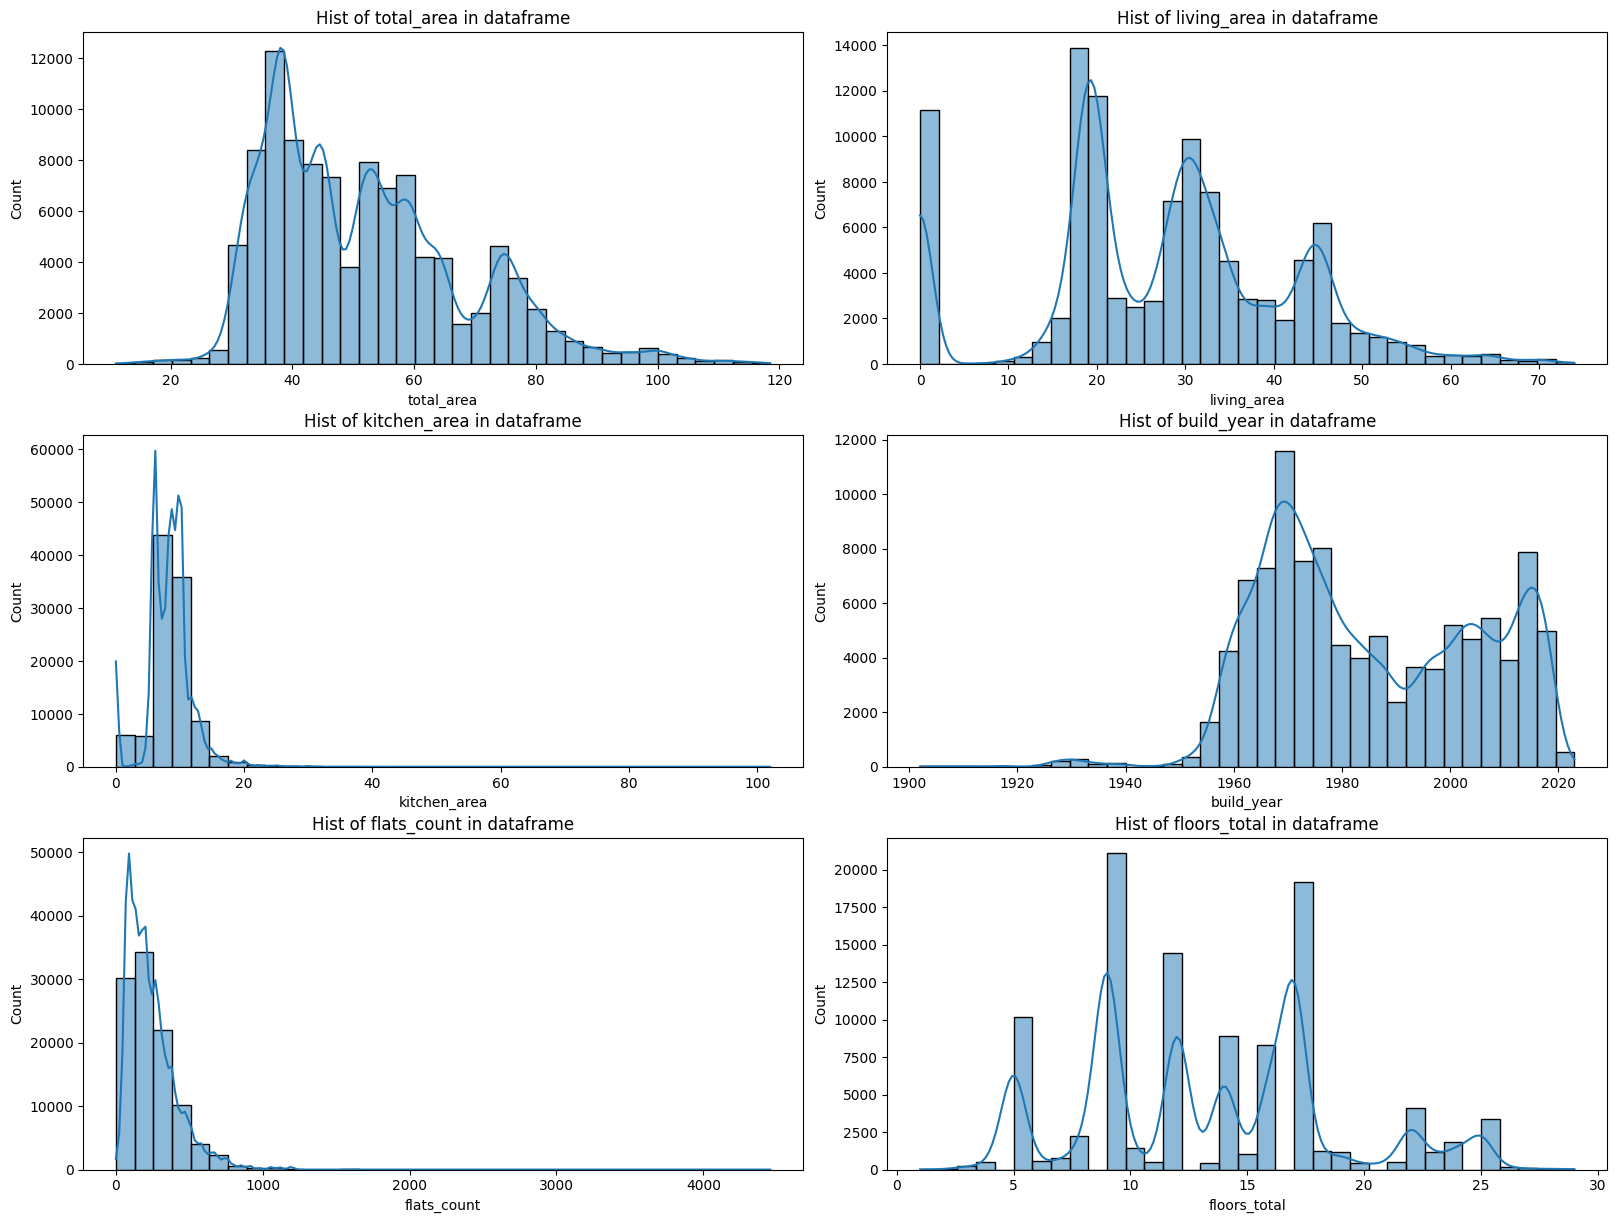

In [13]:
fig, axs = plt.subplots(3, 2)
fig.set_size_inches(16.5, 12.5, forward=True)
fig.tight_layout(pad=3)

x='total_area'
sns.histplot(data=df, x=x, kde=True, bins=35, ax=axs[0, 0])
axs[0, 0].set_title(f'Hist of {x} in dataframe')

x='living_area'
sns.histplot(data=df, x=x, kde=True, bins=35, ax=axs[0, 1])
axs[0, 1].set_title(f'Hist of {x} in dataframe')

x='kitchen_area'
sns.histplot(data=df, x=x, kde=True, bins=35, ax=axs[1, 0])
axs[1, 0].set_title(f'Hist of {x} in dataframe')

x='build_year'
sns.histplot(data=df, x=x, kde=True, bins=35, ax=axs[1, 1])
axs[1, 1].set_title(f'Hist of {x} in dataframe')

x='flats_count'
sns.histplot(data=df, x=x, kde=True, bins=35, ax=axs[2, 0])
axs[2, 0].set_title(f'Hist of {x} in dataframe')

x='floors_total'
sns.histplot(data=df, x=x, kde=True, bins=35, ax=axs[2, 1])
axs[2, 1].set_title(f'Hist of {x} in dataframe')

plt.savefig(os.path.join(ASSETS_DIR, 'num_features_dist'))

In [14]:
# 2.4 Анализ целевой переменной

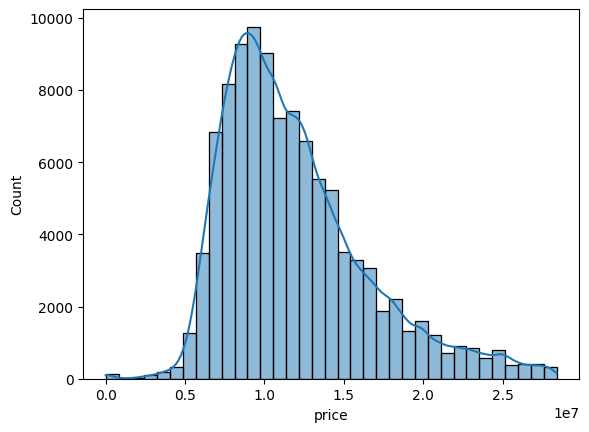

In [15]:
x='price'
sns.histplot(data=df, x=x, kde=True, bins=35)
plt.savefig(os.path.join(ASSETS_DIR, 'dist_of_target'))

In [16]:
df['price'].describe()

count    1.040950e+05
mean     1.192439e+07
std      4.580951e+06
min      1.100000e+01
25%      8.600000e+06
50%      1.099000e+07
75%      1.420000e+07
max      2.840000e+07
Name: price, dtype: float64

In [17]:
# 2.4 Анализ целевой переменной в зависимости от различных признаков

In [18]:
num_cols = ['price','total_area','living_area','kitchen_area','build_year','flats_count','floors_total'
           ,'rooms','ceiling_height','latitude','longitude']

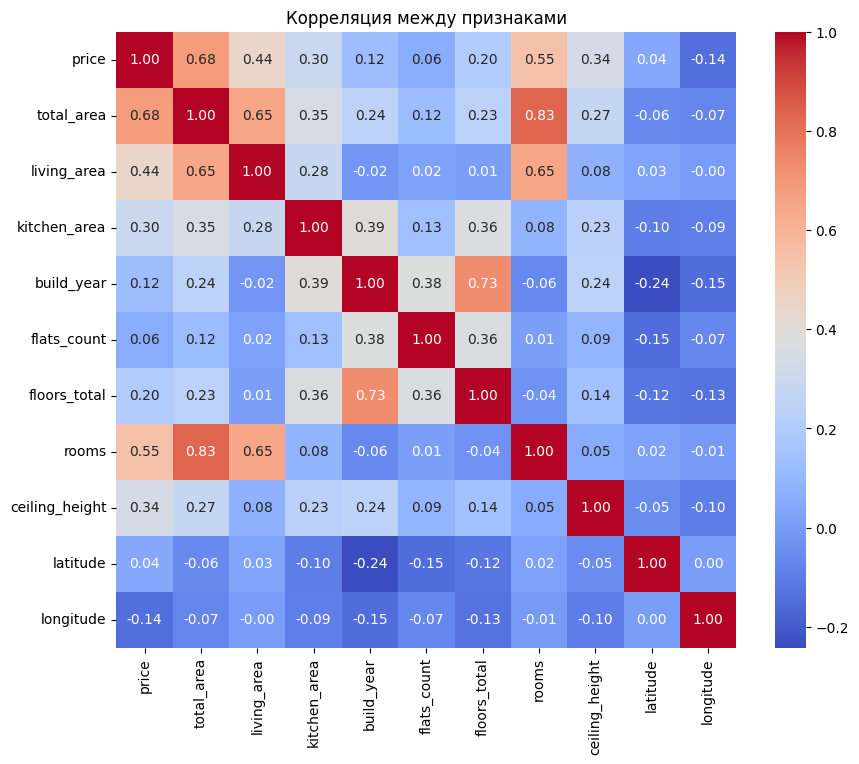

In [19]:
correlations_with_price = df[num_cols].corr()

# Построение тепловой карты
plt.figure(figsize=(10, 8))
sns.heatmap(correlations_with_price, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Корреляция между признаками')

plt.savefig(os.path.join(ASSETS_DIR, 'corr_with_target'))

In [20]:
cat_and_bin_cols = ['is_apartment','has_elevator','building_type_int']

2025-02-25 13:40:44,595 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-02-25 13:40:44,648 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


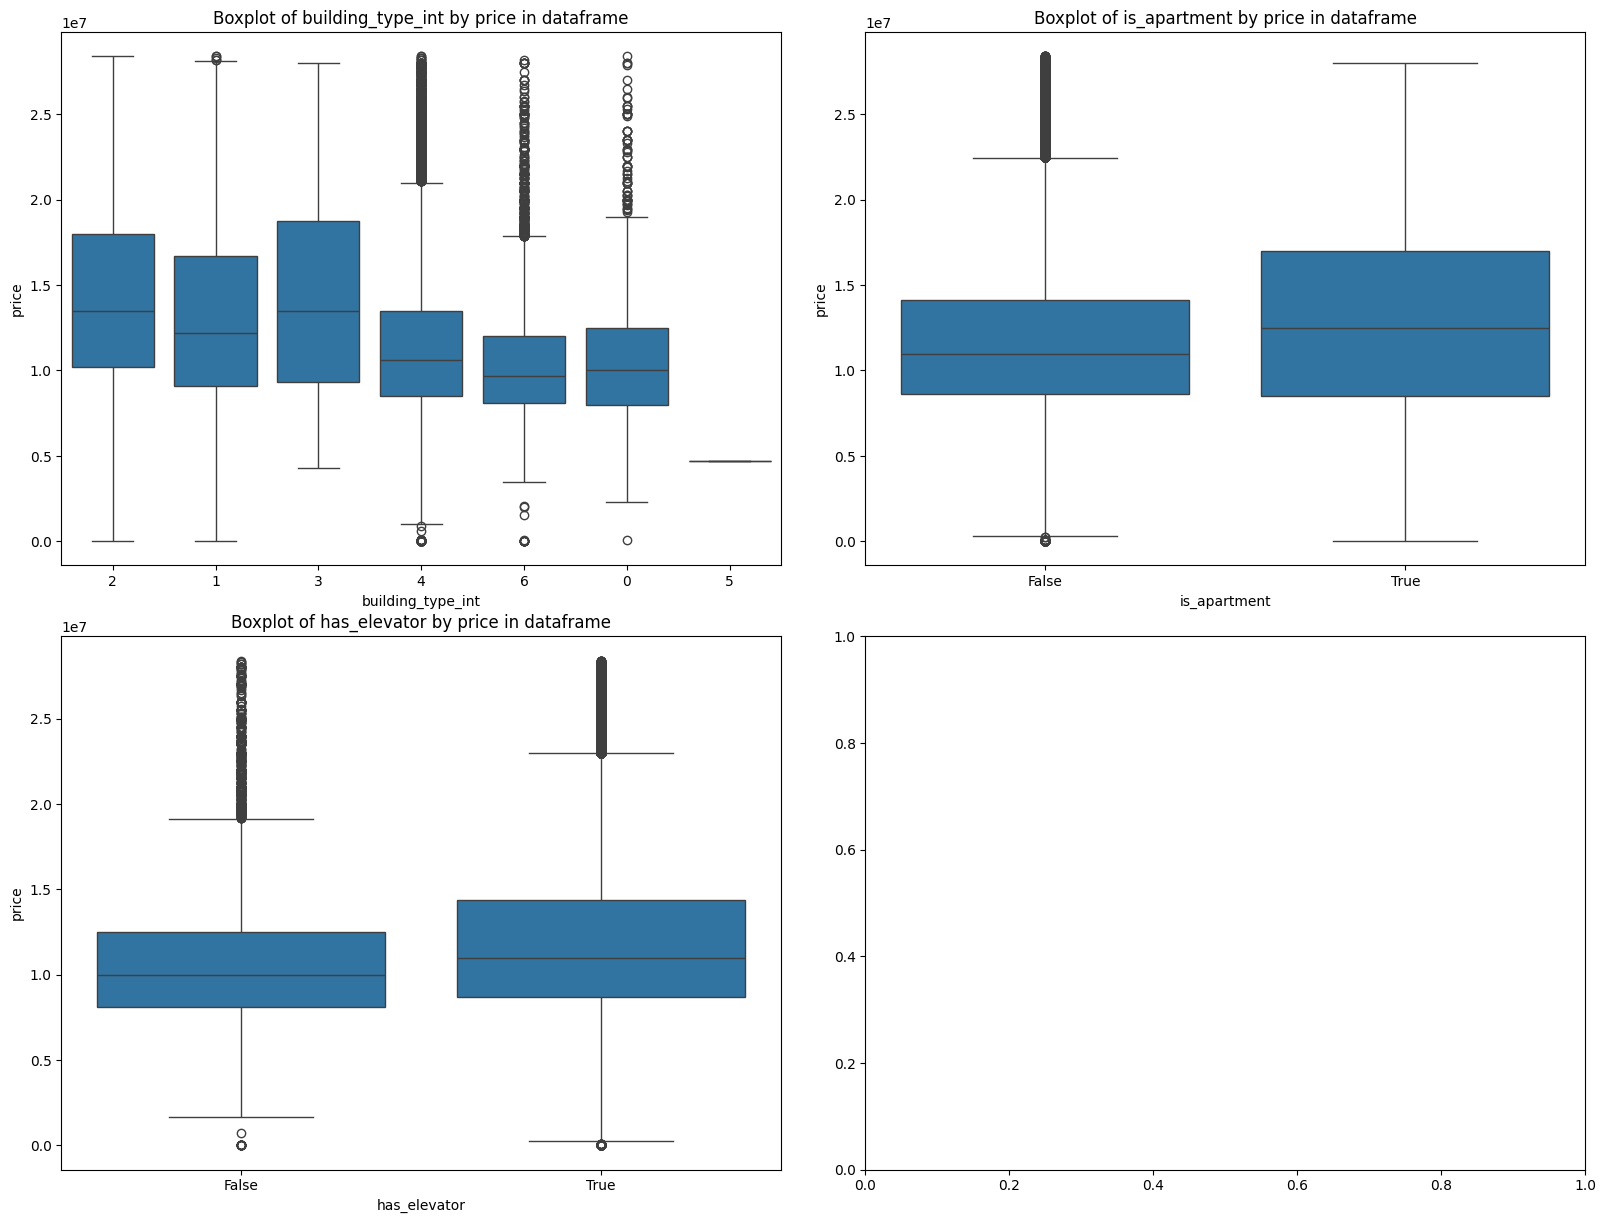

In [21]:
fig, axs = plt.subplots(2, 2)
fig.set_size_inches(16.5, 12.5, forward=True)
fig.tight_layout(pad=3)
y = "price"


x = 'building_type_int'
sns.boxplot(data=df, x=x, y=y, ax=axs[0, 0])
axs[0, 0].set_title(f'Boxplot of {x} by {y} in dataframe')

x = 'is_apartment'
sns.boxplot(data=df, x=x, y=y, ax=axs[0, 1])
axs[0, 1].set_title(f'Boxplot of {x} by {y} in dataframe')

x = 'has_elevator'
sns.boxplot(data=df, x=x, y=y, ax=axs[1, 0])
axs[1, 0].set_title(f'Boxplot of {x} by {y} in dataframe')

plt.savefig(os.path.join(ASSETS_DIR, 'price_boxplot_cat_bin_feats'))

In [22]:
# 2.5 Выводы после EDA

Данные на момент их использования моделью уже были отчищены от выбросов и не имеют пустых значений

Есть лишний признак только с одним значением:
studio

По ряду категориальных и бинарных признаков виден дисбаланс например:
building_type_int 
is_apartment 
has_elevator 

Все числовые признаки несмотря на удаление выбросов имеют тяжелые хвосты

Таргет наиболее "приближен" к нормальному распределению но тоже с тяжелыми хвостами и скосом в лево

Корреляционный анализ показывает что наиболее сильные признаки это признаки которые непосредственно касаются размера квартиры kitchen_area living_area ceiling_height total_area

Также разбивка таргета по категориальным и бинырным фичам boxplot показывает что между различными категориями есть разница в цене првада building_type_int = 5 имеет слишком мало значений чтобы его можно было анализировать

In [23]:
# 2.6 логирование артефактов в MLflow

In [24]:
markdown_content = """# Ключевые выводы EDA
Данные на момент их использования моделью уже были отчищены от выбросов и не имеют пустых значений

Есть лишний признак только с одним значением:
studio

По ряду категориальных и бинарных признаков виден дисбаланс например:
building_type_int 
is_apartment 
has_elevator 

Все числовые признаки несмотря на удаление выбросов имеют тяжелые хвосты

Таргет наиболее "приближен" к нормальному распределению но тоже с тяжелыми хвостами и скосом в лево

Корреляционный анализ показывает что наиболее сильные признаки это признаки которые непосредственно касаются размера квартиры kitchen_area living_area ceiling_height total_area

Также разбивка таргета по категориальным и бинырным фичам boxplot показывает что между различными категориями есть разница в цене првада building_type_int = 5 имеет слишком мало значений чтобы его можно было анализировать
"""
markdown_file = f"{ASSETS_DIR}/eda_summary.md"
with open(markdown_file, "w") as f:
    f.write(markdown_content)


In [26]:
EXPERIMENT_NAME = "sprint2_appartment_price"
RUN_NAME = "save_stage_2_eda"

experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
if not experiment:
    experiment_id = mlflow.create_experiment(EXPERIMENT_NAME)
else:
    experiment_id = experiment.experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id
    notebook_path = "project_sprint_2.ipynb"
    mlflow.log_artifact(notebook_path)

    mlflow.log_artifacts(ASSETS_DIR) 

2025-02-25 13:41:24,529 INFO: Found credentials in environment variables.


#### Этап 3: Генерация Признаков и Обучение Новой Версии Модели
После тщательного исследовательского анализа данных (EDA), вы, скорее всего, сформировали несколько гипотез относительно новых признаков, которые могут улучшить качество вашей модели. На этом этапе, мы предлагаем вам приступить к генерации новых признаков и последующему обучению модели, используя два подхода:

Ручная генерация признаков: Используйте ваше понимание данных и результаты EDA для создания новых признаков.
Автоматическая генерация признаков: Воспользуйтесь библиотеками для автоматической генерации признаков, чтобы облегчить и ускорить этот процесс.
Важно: Для признаков, созданных вручную, рекомендуется использовать объекты sklearn, такие как Pipeline и ColumnTransformer. Это позволит автоматизировать процесс преобразования данных и облегчить поддержку вашего проекта.

После генерации новых признаков, наступает время обучить новую версию вашей модели, используя эти признаки. Не забудьте залогировать все результаты, включая новые признаки, параметры модели и метрики качества, в MLflow для удобства отслеживания изменений и результатов.

Рекомендуемые шаги:

- Определение и генерация новых признаков на основе ваших гипотез.
- Использование библиотек для автоматической генерации признаков, если это применимо.
- Интеграция новых признаков в вашу модель с помощью Pipeline или ColumnTransformer для ручно созданных признаков.
- Обучение новой версии модели с использованием всех доступных признаков.
- Логирование результатов в MLflow для документирования и анализа эффективности новых признаков и модели.

Этот этап проекта критически важен для повышения точности и эффективности вашей модели. Тщательная работа на этом этапе может существенно повлиять на итоговое качество моделирования.


In [ ]:
# 3.1 ручная генерация признаков

In [29]:
X_train['ratio_living_area'] = X_train['living_area'] / X_train['total_area']
X_test['ratio_living_area'] = X_test['living_area'] / X_test['total_area']

X_train['ratio_kitchen_area'] = X_train['kitchen_area'] / X_train['total_area']
X_test['ratio_kitchen_area'] = X_test['kitchen_area'] / X_test['total_area']

X_train['mean_flats_area'] = X_train['total_area'] / X_train['flats_count']
X_test['mean_flats_area'] = X_test['total_area'] / X_test['flats_count']

In [34]:
cat_cols = ['building_type_int']
bin_cols = ['is_apartment','has_elevator']
num_features = ['total_area','living_area','kitchen_area','build_year','flats_count','floors_total'
           ,'rooms','ceiling_height','ratio_living_area','ratio_kitchen_area','mean_flats_area']
geo_feats=['latitude','longitude']

features = cat_cols + num_features + bin_cols + geo_feats

transformations = ("1/", "exp", "log","sin", "cos", "exp-")

In [35]:
# 3.2 оборачивание всех преобразований в объекты sklearn

In [36]:
afc = AutoFeatRegressor(transformations=transformations, feateng_steps=1, n_jobs=-1)


In [37]:
# 3.3 автоматическая генерация признаков

In [ ]:

preprocessor = ColumnTransformer(
        [
        ('binary', OneHotEncoder(drop='if_binary'), bin_cols),
        ('cat', CatBoostEncoder(return_df=False), cat_cols),
        ('num', StandardScaler(), num_features+geo_feats),
        ('poly', PolynomialFeatures(degree=2, include_bias=False), num_features),
        ('kbin', KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform'), num_features)
        ],
        remainder='drop',
        verbose_feature_names_out=False
        )

model = CatBoostRegressor(loss_function='RMSE')

pipeline = Pipeline(
[
    ('preprocessor', preprocessor),
    ('autofeat', afc),
    ('model', model)
]
)

cv_res = cross_validate(
    pipeline,
    X_train[features],
    y_train,
    cv=4,
    n_jobs=-1,
    scoring=['neg_root_mean_squared_error', 'r2','neg_mean_absolute_percentage_error']
    )

for key, value in cv_res.items():
    cv_res[key] = round(value.mean(), 3)  



/home/mle-user/mle-project-sprint-2-v001/.venv_sprint/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
/home/mle-user/mle-project-sprint-2-v001/.venv_sprint/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
/home/mle-user/mle-project-sprint-2-v001/.venv_sprint/lib/python3.10/site-packages/sklearn/linear_model/_least_angle.py:718: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 68 iterations, alpha=4.479e-03, previous

Learning rate set to 0.078683
0:	learn: 4380490.2201609	total: 183ms	remaining: 3m 3s
1:	learn: 4205097.0056260	total: 293ms	remaining: 2m 25s
2:	learn: 4047661.8283871	total: 393ms	remaining: 2m 10s
3:	learn: 3903146.7977650	total: 502ms	remaining: 2m 4s
4:	learn: 3774971.5465243	total: 609ms	remaining: 2m 1s
5:	learn: 3657848.3262511	total: 712ms	remaining: 1m 58s
6:	learn: 3552367.9316250	total: 820ms	remaining: 1m 56s
7:	learn: 3461005.2287758	total: 927ms	remaining: 1m 55s
8:	learn: 3378399.6904386	total: 1.04s	remaining: 1m 54s
9:	learn: 3306189.3275152	total: 1.16s	remaining: 1m 54s
10:	learn: 3238792.1708904	total: 1.27s	remaining: 1m 54s
11:	learn: 3178473.0737498	total: 1.38s	remaining: 1m 53s
12:	learn: 3125693.3873147	total: 1.47s	remaining: 1m 51s
13:	learn: 3078984.4481005	total: 1.57s	remaining: 1m 50s
14:	learn: 3031598.2178394	total: 1.68s	remaining: 1m 50s
15:	learn: 2991032.2311312	total: 1.78s	remaining: 1m 49s
16:	learn: 2954719.8747812	total: 1.89s	remaining: 1m 4

In [ ]:
cv_res

In [8]:
# 3.4 обучение новой версии модели

In [9]:
pipeline.fit(X_train, y_train)

989:	learn: 2228408.9008351	total: 54.7s	remaining: 552ms
990:	learn: 2228132.2424276	total: 54.7s	remaining: 497ms
991:	learn: 2227844.1237229	total: 54.8s	remaining: 442ms
992:	learn: 2227700.2238540	total: 54.9s	remaining: 387ms
993:	learn: 2227442.9214951	total: 54.9s	remaining: 332ms
994:	learn: 2227122.9925847	total: 55s	remaining: 276ms
995:	learn: 2226883.3714033	total: 55.1s	remaining: 221ms
996:	learn: 2226787.4353673	total: 55.1s	remaining: 166ms
997:	learn: 2226570.2843411	total: 55.2s	remaining: 111ms
998:	learn: 2226308.2761139	total: 55.2s	remaining: 55.3ms
999:	learn: 2225954.3616772	total: 55.3s	remaining: 0us
Learning rate set to 0.082342
0:	learn: 4374834.2562102	total: 86.8ms	remaining: 1m 26s
1:	learn: 4200765.8461851	total: 120ms	remaining: 59.9s
2:	learn: 4040864.7525416	total: 158ms	remaining: 52.5s
3:	learn: 3896699.9329598	total: 197ms	remaining: 49.1s
4:	learn: 3768040.9039090	total: 233ms	remaining: 46.3s
5:	learn: 3658337.4757943	total: 268ms	remaining: 44.

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('binary',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['is_apartment',
                                                   'has_elevator']),
                                                 ('cat',
                                                  CatBoostEncoder(return_df=False),
                                                  ['building_type_int']),
                                                 ('num', StandardScaler(),
                                                  ['total_area', 'living_area',
                                                   'kitchen_area', 'build_year',
                                                   'flats_count',
                                                   'floors_total', 'rooms',
                                                   'ceiling_height', 'latitude',
                                                   'lo...
                                                  KBinsDiscretizer(encode='ordinal',
                                                                   strategy='uniform'),
                                                  ['total_area', 'living_area',
                                                   'kitchen_area', 'build_year',
                                                   'flats_count',
                                                   'floors_total', 'rooms',
                                                   'ceiling_height'])],
                                   verbose_feature_names_out=False)),
                ('autofeat',
                 AutoFeatRegressor(feateng_steps=1, n_jobs=-1,
                                   transformations=('log',))),
                ('model',
                 <catboost.core.CatBoostRegressor object at 0x7fa5c0f02a40>)])

In [ ]:
# 3.5 логирование артефактов в MLflow

In [14]:
EXPERIMENT_NAME = "sprint2"
RUN_NAME = "save_model_selected_feats"
REGISTRY_MODEL_NAME = "model_price_appartment"

input_example =  X_train[features][:10]
prediction = pipeline.predict(input_example[:10])
signature = mlflow.models.infer_signature(input_example, prediction)

experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
if not experiment:
    experiment_id = mlflow.create_experiment(EXPERIMENT_NAME)
else:
    experiment_id = experiment.experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id

    mlflow.log_metrics(cv_res)
    
    model_info = mlflow.sklearn.log_model(
        pipeline, 
        artifact_path="models",
        registered_model_name=REGISTRY_MODEL_NAME,
        signature=signature,
        input_example=input_example,
        await_registration_for=60
		)

2025-02-11 13:16:05,111 INFO: Found credentials in environment variables.
Registered model 'model_price_appartment' already exists. Creating a new version of this model...
2025/02/11 13:16:06 INFO mlflow.tracking._model_registry.client: Waiting up to 60 seconds for model version to finish creation. Model name: model_price_appartment, version 2
Created version '2' of model 'model_price_appartment'.


995:	learn: 2222968.7897725	total: 51.6s	remaining: 207ms
996:	learn: 2222619.6059490	total: 51.7s	remaining: 155ms
997:	learn: 2222405.4098362	total: 51.7s	remaining: 104ms
998:	learn: 2222184.0159815	total: 51.8s	remaining: 51.8ms
999:	learn: 2222046.4907564	total: 51.8s	remaining: 0us
994:	learn: 2236535.7991272	total: 43.7s	remaining: 219ms
995:	learn: 2236354.1080830	total: 43.7s	remaining: 175ms
996:	learn: 2236109.7569414	total: 43.7s	remaining: 132ms
997:	learn: 2235940.6491266	total: 43.7s	remaining: 87.6ms
998:	learn: 2235739.6902872	total: 43.8s	remaining: 43.8ms
999:	learn: 2235586.9948220	total: 43.8s	remaining: 0us


#### Этап 4: Отбор Признаков и Обучение Новой Версии Модели
Создание новых признаков — это лишь часть работы. Следующий важный шаг — это убедиться в том, что каждый из этих признаков действительно вносит положительный вклад в качество модели. Некоторые признаки могут оказывать отрицательное влияние на модель, поэтому их следует исключить из анализа.

На этом этапе, мы рекомендуем вам применить различные методы отбора признаков для того, чтобы определить и удалить те признаки, которые не улучшают качество вашей модели. Цель этого этапа — максимизировать производительность модели, удалив избыточные или неинформативные признаки.

После тщательного отбора признаков, пора обучить новую версию вашей модели, уже без негативно влияющих на неё признаков. Важно залогировать результаты этого этапа, включая измененный набор признаков, параметры модели и полученные метрики качества, в MLflow для последующего анализа и сравнения.

Рекомендуемые шаги:

- Применение методов отбора признаков для идентификации и исключения признаков, ухудшающих качество модели.
- Анализ влияния каждого признака на модель, чтобы понять, какие из них наиболее ценные.
- Обучение новой версии модели без негативно влияющих признаков.
- Логирование всех изменений и результатов в MLflow, включая конечный набор признаков, параметры модели и метрики качества.

Этот этап не только поможет улучшить качество вашей модели, но и даст глубокое понимание о важности и влиянии отдельных признаков на результаты моделирования.


In [5]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [6]:
# 4.1 Отбор признаков при помощи метода номер 1

In [7]:
cat_cols = ['building_type_int']
bin_cols = ['is_apartment','has_elevator']
num_features = ['total_area','living_area','kitchen_area','build_year','flats_count','floors_total'
           ,'rooms','ceiling_height']
geo_feats=['latitude','longitude']

features = cat_cols + num_features + bin_cols + geo_feats

transformations = ("log",)
afc = AutoFeatRegressor(transformations=transformations, feateng_steps=1, n_jobs=-1)

In [8]:
# Создание ColumnTransformer с уникальными именами признаков
preprocessor = ColumnTransformer(
    [
        ('binary', OneHotEncoder(drop='if_binary', sparse_output=False), bin_cols),
        ('cat', CatBoostEncoder(return_df=False), cat_cols),
        ('num', StandardScaler(), num_features + geo_feats),
        ('poly', PolynomialFeatures(degree=2, include_bias=False), num_features),
        ('kbin', KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform'), num_features)
    ],
    remainder='drop',
    verbose_feature_names_out=True  # Включить префиксы для имен признаков
)

# Преобразование тренировочных данных
X_train_tr = preprocessor.fit_transform(X_train, y_train)
feature_names = preprocessor.get_feature_names_out()  # Имена признаков с префиксами
X_train_tr = pd.DataFrame(X_train_tr, columns=feature_names)

# Применение AutoFeatRegressor к тренировочным данным
X_train_tr = afc.fit_transform(X_train_tr, y_train)

# Преобразование тестовых данных
X_test_tr = preprocessor.transform(X_test)
X_test_tr = pd.DataFrame(X_test_tr, columns=feature_names)

# Применение AutoFeatRegressor к тестовым данным
X_test_tr = afc.transform(X_test_tr)


In [9]:
model = LinearRegression()


sfs = SFS(model, k_features=30, forward=True, floating=False, scoring='neg_root_mean_squared_error',
            verbose=2, cv=4, n_jobs=-1)

sfs = sfs.fit(X_train_tr, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  67 out of  67 | elapsed:    1.0s finished

[2025-02-25 12:27:07] Features: 1/30 -- score: -3288762.7904761573[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  66 out of  66 | elapsed:    1.7s finished

[2025-02-25 12:27:08] Features: 2/30 -- score: -3262675.0633555995[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  65 out of  65 | elapsed:    1.8s finished

[2025-02-25 12:27:10] Features: 3/30 -- score: -3234886.8453540187[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  64 out of  64 | elapsed:    2.1s finished

[2025-02-25 12:27:12] Features: 4/30 -- score: -3219080.984905079[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  63 out of  63 | elapsed:    2.4s finishe

In [10]:
# 4.2 Отбор признаков при помощи метода номер 2

In [11]:
model = LinearRegression()

sbs = SFS(model, k_features=20, forward=False, floating=False, scoring='neg_root_mean_squared_error',
            verbose=2, cv=4, n_jobs=-1)

sbs = sbs.fit(X_train_tr, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   36.9s
[Parallel(n_jobs=-1)]: Done  67 out of  67 | elapsed:  1.1min finished

[2025-02-25 12:30:38] Features: 66/20 -- score: -3113542.4414187646[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   33.3s
[Parallel(n_jobs=-1)]: Done  66 out of  66 | elapsed:   58.2s finished

[2025-02-25 12:31:36] Features: 65/20 -- score: -3113457.8406269634[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   34.2s
[Parallel(n_jobs=-1)]: Done  65 out of  65 | elapsed:   59.8s finished

[2025-02-25 12:32:36] Features: 64/20 -- score: -3113390.321681998[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   32.0s
[Parallel(n_jobs=-1)]: Done  64 

In [12]:
# 4.3 Анализ отобранных признаков при помощи двух методов и формирование финального списка с признаками для модели

In [13]:
top_sfs = list(sfs.k_feature_names_)
top_sbs = list(sbs.k_feature_names_)

print('\nSequential Forward Selection (k=30)')
print('CV Score:')
print(sfs.k_score_)

print('\nSequential Backward Selection')
print('CV Score:')
print(sbs.k_score_)

sfs_df = pd.DataFrame.from_dict(sfs.get_metric_dict()).T
sbs_df = pd.DataFrame.from_dict(sbs.get_metric_dict()).T 


Sequential Forward Selection (k=30)
CV Score:
-3118485.1610347275

Sequential Backward Selection
CV Score:
-3123703.6869868482


In [14]:
sfs_df

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(28,)","[-3297712.238667263, -3307835.516429311, -3288...",-3288762.790476,"(poly__total_area ceiling_height,)",27907.837691,17409.95805,10051.643967
2,"(2, 28)","[-3270956.0235951045, -3285374.1610909416, -32...",-3262675.063356,"(cat__building_type_int, poly__total_area ceil...",28879.542617,18016.144104,10401.625648
3,"(2, 11, 28)","[-3244113.5885997172, -3255862.4842655533, -32...",-3234886.845354,"(cat__building_type_int, num__latitude, poly__...",28264.315333,17632.342202,10180.037516
4,"(2, 11, 12, 28)","[-3226568.216646913, -3242509.3865510854, -321...",-3219080.984905,"(cat__building_type_int, num__latitude, num__l...",28906.819478,18033.160435,10411.450031
5,"(2, 6, 11, 12, 28)","[-3214145.574403245, -3229403.5161716286, -320...",-3207065.825262,"(cat__building_type_int, num__build_year, num_...",28167.992784,17572.252575,10145.344754
6,"(2, 6, 11, 12, 28, 53)","[-3170900.352117226, -3193317.9743770026, -316...",-3165697.067191,"(cat__building_type_int, num__build_year, num_...",33041.697369,20612.65267,11900.720568
7,"(2, 6, 11, 12, 28, 40, 53)","[-3162657.0113522266, -3182891.002050294, -315...",-3155381.53462,"(cat__building_type_int, num__build_year, num_...",34642.138155,21611.067784,12477.155803
8,"(2, 6, 11, 12, 21, 28, 40, 53)","[-3155886.2246769643, -3174225.3594725323, -31...",-3147989.570042,"(cat__building_type_int, num__build_year, num_...",34176.977933,21320.883355,12309.617744
9,"(2, 6, 11, 12, 21, 28, 40, 53, 60)","[-3151920.772244464, -3171435.761654815, -3143...",-3144724.226434,"(cat__building_type_int, num__build_year, num_...",34120.281896,21285.514236,12289.197374
10,"(2, 6, 11, 12, 21, 26, 28, 40, 53, 60)","[-3148592.3129068804, -3169708.138185392, -314...",-3141419.027884,"(cat__building_type_int, num__build_year, num_...",36019.706577,22470.446741,12973.318475


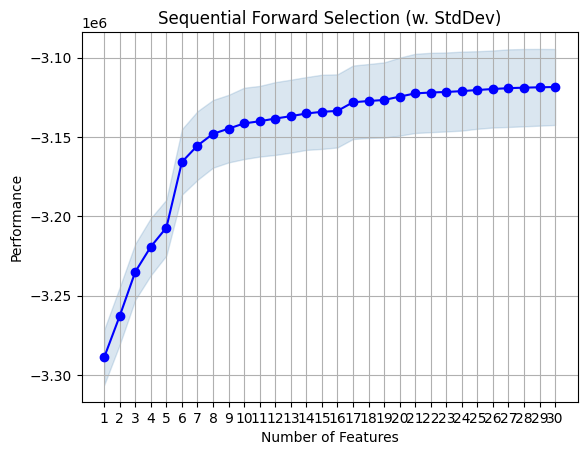

<Figure size 640x480 with 0 Axes>

In [15]:
fig = plot_sfs(sfs.get_metric_dict(), kind='std_dev')

plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.show()

plt.savefig(f"{FS_ASSETS_DI}/sfs.png") 

In [16]:
sfs_df['feature_names'][10]

('cat__building_type_int',
 'num__build_year',
 'num__latitude',
 'num__longitude',
 'poly__total_area^2',
 'poly__total_area floors_total',
 'poly__total_area ceiling_height',
 'poly__kitchen_area rooms',
 'poly__floors_total ceiling_height',
 'kbin__build_year')

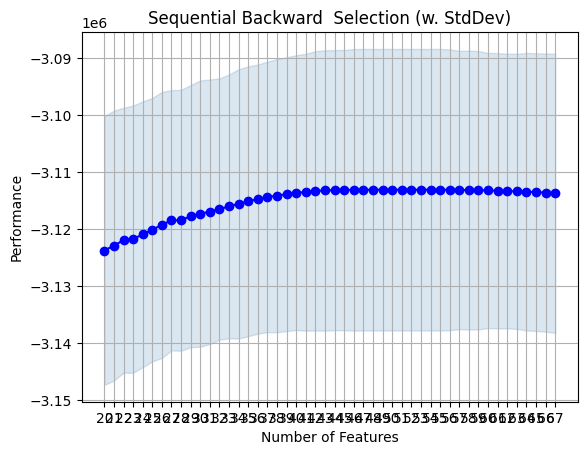

<Figure size 640x480 with 0 Axes>

In [17]:
fig = plot_sfs(sbs.get_metric_dict(), kind='std_dev')

plt.title('Sequential Backward  Selection (w. StdDev)')
plt.grid()
plt.show()

plt.savefig(f"{FS_ASSETS_DI}/sbs.png") 

В целом видно что наиболее важными фичами оказались 'cat__building_type_int', 'num__build_year',
 'num__latitude'
 'num__longitude,
 'poly__total_area^',
 'poly__total_area floors_totl',
 'poly__total_area ceiling_heiht',
 'poly__kitchen_area roms',
 'poly__floors_total ceiling_hight',
 'kbin__bu
что соответсвует логике напримерестественно что наиболее значимыми фичами будут фичи связанные с размером квратиры и годом постройки единственное что смущает так это наличие одновременно num__build_year и kbin__build_yearild_year'

In [18]:
# 4.4 Обучение новой версии модели

In [19]:
from sklearn.preprocessing import FunctionTransformer

# Функция для преобразования массива в DataFrame с правильными именами признаков
def to_dataframe(X):
    return pd.DataFrame(X, columns=preprocessor.get_feature_names_out())

# Функция для выбора нужных признаков
def select_features(X):
    selected_features = [f for f in preprocessor.get_feature_names_out() if f in top_sfs]
    return X[selected_features]

In [20]:
# Здесь мы добавим отбор фичей в  модель используя список top_sfs
preprocessor = ColumnTransformer(
    [
        ('binary', OneHotEncoder(drop='if_binary', sparse_output=False), bin_cols),
        ('cat', CatBoostEncoder(return_df=False), cat_cols),
        ('num', StandardScaler(), num_features + geo_feats),
        ('poly', PolynomialFeatures(degree=2, include_bias=False), num_features),
        ('kbin', KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform'), num_features)
    ],
    remainder='drop',
    verbose_feature_names_out=True
)

model = CatBoostRegressor(loss_function='RMSE')

preprocessor.fit(X_train, y_train)


pipeline = Pipeline(
[
    ('preprocessor', preprocessor), 
    ('to_dataframe', FunctionTransformer(to_dataframe)),  
    ('feature_selection', FunctionTransformer(select_features)),
    ('model', model)
]
)

cv_res = cross_validate(
    pipeline,
    X_train[features],
    y_train,
    cv=4,
    n_jobs=-1,
    scoring=['neg_root_mean_squared_error', 'r2','neg_mean_absolute_percentage_error']
    )

for key, value in cv_res.items():
    cv_res[key] = round(value.mean(), 3)  



/home/mle-user/mle-project-sprint-2-v001/.venv_sprint/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
/home/mle-user/mle-project-sprint-2-v001/.venv_sprint/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(


Learning rate set to 0.078683
0:	learn: 4391646.2310254	total: 106ms	remaining: 1m 45s
1:	learn: 4213334.6988549	total: 144ms	remaining: 1m 11s
2:	learn: 4050578.9717079	total: 179ms	remaining: 59.6s
3:	learn: 3914956.6278196	total: 218ms	remaining: 54.3s
4:	learn: 3794174.8318136	total: 257ms	remaining: 51.1s
5:	learn: 3686967.7251859	total: 288ms	remaining: 47.8s
6:	learn: 3581668.2981346	total: 324ms	remaining: 46s
7:	learn: 3490682.6696140	total: 358ms	remaining: 44.4s
8:	learn: 3416212.0685762	total: 392ms	remaining: 43.2s
9:	learn: 3347875.6544168	total: 429ms	remaining: 42.5s
10:	learn: 3290506.6616452	total: 466ms	remaining: 41.9s
11:	learn: 3239071.4521933	total: 498ms	remaining: 41s
12:	learn: 3191435.0489747	total: 533ms	remaining: 40.4s
13:	learn: 3147406.9795279	total: 565ms	remaining: 39.8s
14:	learn: 3107671.2670666	total: 593ms	remaining: 39s
15:	learn: 3066012.6043787	total: 631ms	remaining: 38.8s
16:	learn: 3029372.8262451	total: 666ms	remaining: 38.5s
17:	learn: 2999

/home/mle-user/mle-project-sprint-2-v001/.venv_sprint/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
/home/mle-user/mle-project-sprint-2-v001/.venv_sprint/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(


994:	learn: 2249807.9632150	total: 31.7s	remaining: 159ms
995:	learn: 2249632.7200786	total: 31.7s	remaining: 127ms
996:	learn: 2249463.9193445	total: 31.7s	remaining: 95.5ms
997:	learn: 2249264.9607416	total: 31.8s	remaining: 63.7ms
998:	learn: 2249108.3184959	total: 31.8s	remaining: 31.8ms
999:	learn: 2248906.7714417	total: 31.8s	remaining: 0us
Learning rate set to 0.078683
0:	learn: 4376342.7262843	total: 41.4ms	remaining: 41.4s
1:	learn: 4201483.6395485	total: 89.2ms	remaining: 44.5s
2:	learn: 4041866.5619332	total: 127ms	remaining: 42.1s
3:	learn: 3902918.5819086	total: 166ms	remaining: 41.2s
4:	learn: 3783819.1808546	total: 202ms	remaining: 40.2s
5:	learn: 3678441.8528842	total: 241ms	remaining: 39.9s
6:	learn: 3584369.7965917	total: 255ms	remaining: 36.2s
7:	learn: 3499068.1741506	total: 291ms	remaining: 36.1s
8:	learn: 3426034.9623624	total: 329ms	remaining: 36.2s
9:	learn: 3361118.6382314	total: 360ms	remaining: 35.6s
10:	learn: 3304418.8845011	total: 393ms	remaining: 35.3s
11

In [21]:
cv_res

{'fit_time': 33.502,
 'score_time': 0.112,
 'test_neg_root_mean_squared_error': -2441210.084,
 'test_r2': 0.716,
 'test_neg_mean_absolute_percentage_error': -20.982}

После добавления новых фич качество ухудшилось примерно на 1%

In [22]:
pipeline.fit(X_train[features], y_train)

Learning rate set to 0.082342
0:	learn: 4380286.7156320	total: 67.8ms	remaining: 1m 7s
1:	learn: 4196822.0423199	total: 86.5ms	remaining: 43.2s
2:	learn: 4029431.1979503	total: 105ms	remaining: 34.7s
3:	learn: 3887855.9325465	total: 123ms	remaining: 30.7s
4:	learn: 3763262.3391209	total: 141ms	remaining: 28.1s
5:	learn: 3647716.9610082	total: 159ms	remaining: 26.4s
6:	learn: 3544756.5123909	total: 178ms	remaining: 25.2s
7:	learn: 3455348.1180507	total: 198ms	remaining: 24.5s
8:	learn: 3371642.9356086	total: 216ms	remaining: 23.8s
9:	learn: 3300655.9276330	total: 234ms	remaining: 23.1s
10:	learn: 3243072.7668205	total: 251ms	remaining: 22.6s
11:	learn: 3189350.1653186	total: 269ms	remaining: 22.2s
12:	learn: 3141179.0819688	total: 285ms	remaining: 21.6s
13:	learn: 3098592.5598999	total: 301ms	remaining: 21.2s
14:	learn: 3057989.6773521	total: 318ms	remaining: 20.9s
15:	learn: 3021746.4431227	total: 334ms	remaining: 20.5s
16:	learn: 2988303.3068942	total: 350ms	remaining: 20.2s
17:	learn

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('binary',
                                                  OneHotEncoder(drop='if_binary',
                                                                sparse_output=False),
                                                  ['is_apartment',
                                                   'has_elevator']),
                                                 ('cat',
                                                  CatBoostEncoder(return_df=False),
                                                  ['building_type_int']),
                                                 ('num', StandardScaler(),
                                                  ['total_area', 'living_area',
                                                   'kitchen_area', 'build_year',
                                                   'flats_count',
                                                   'floors_total', 'rooms',
                                                   'ceiling_he...
                                                  ['total_area', 'living_area',
                                                   'kitchen_area', 'build_year',
                                                   'flats_count',
                                                   'floors_total', 'rooms',
                                                   'ceiling_height'])])),
                ('to_dataframe',
                 FunctionTransformer(func=<function to_dataframe at 0x7f0d6b566dd0>)),
                ('feature_selection',
                 FunctionTransformer(func=<function select_features at 0x7f0d6e9cc5e0>)),
                ('model',
                 <catboost.core.CatBoostRegressor object at 0x7f0d6c4c45e0>)])

986:	learn: 2264973.0835442	total: 32.7s	remaining: 431ms
987:	learn: 2264765.4158225	total: 32.8s	remaining: 398ms
988:	learn: 2264722.3635737	total: 32.8s	remaining: 365ms
989:	learn: 2264486.4315792	total: 32.8s	remaining: 332ms
990:	learn: 2264347.9018368	total: 32.9s	remaining: 298ms
991:	learn: 2264164.2121226	total: 32.9s	remaining: 265ms
992:	learn: 2264033.6092741	total: 32.9s	remaining: 232ms
993:	learn: 2263873.9015595	total: 33s	remaining: 199ms
994:	learn: 2263721.6352016	total: 33s	remaining: 166ms
995:	learn: 2263467.1519084	total: 33s	remaining: 133ms
996:	learn: 2263304.2438198	total: 33s	remaining: 99.4ms
997:	learn: 2263185.8261214	total: 33.1s	remaining: 66.3ms
998:	learn: 2263081.9975001	total: 33.1s	remaining: 33.1ms
999:	learn: 2262921.9706954	total: 33.1s	remaining: 0us
987:	learn: 2258393.1290578	total: 32.7s	remaining: 398ms
988:	learn: 2258326.4658551	total: 32.8s	remaining: 365ms
989:	learn: 2258128.4657368	total: 32.8s	remaining: 331ms
990:	learn: 2257970.7

In [ ]:
# 4.5 Логирование всех артефактов в MLflow

In [40]:
EXPERIMENT_NAME = "sprint2"
RUN_NAME = "save_model_new_feats"
REGISTRY_MODEL_NAME = "model_price_appartment"

input_example =  X_train[features][:10]
prediction = pipeline.predict(input_example[:10])
signature = mlflow.models.infer_signature(input_example, prediction)

experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
if not experiment:
    experiment_id = mlflow.create_experiment(EXPERIMENT_NAME)
else:
    experiment_id = experiment.experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id

    mlflow.log_metrics(cv_res)

    mlflow.log_artifacts(FS_ASSETS_DI) 
    
    model_info = mlflow.sklearn.log_model(
        pipeline, 
        artifact_path="models",
        registered_model_name=REGISTRY_MODEL_NAME,
        signature=signature,
        input_example=input_example,
        await_registration_for=60
		)

2025-02-25 06:53:16,527 INFO: Found credentials in environment variables.
Registered model 'model_price_appartment' already exists. Creating a new version of this model...
2025/02/25 06:53:20 INFO mlflow.tracking._model_registry.client: Waiting up to 60 seconds for model version to finish creation. Model name: model_price_appartment, version 3
Created version '3' of model 'model_price_appartment'.


### Этап 5 - подбор гиперпараметров и обучение новой версии модели
После того как мы уделили значительное внимание качеству модели через создание и отбор признаков, пришло время для финального штриха — подбора гиперпараметров. Этот этап является ключевым в финальной части проекта второго спринта, где ваша задача — оптимизировать гиперпараметры модели для достижения наилучшего качества.

Рекомендуется подобрать гиперпараметры как минимум двумя различными методами (например, с использованием Grid Search и Random Search), чтобы вы могли сравнить результаты и выбрать наиболее эффективный набор гиперпараметров для вашей модели. После определения оптимальных гиперпараметров, наступает время обучить финальную версию модели, используя ваши новые признаки.

Рекомендуемые шаги:

- Выбор методов для подбора гиперпараметров: Определитесь с методами, которые вы будете использовать для подбора гиперпараметров (например, Grid Search, Random Search, Bayesian Optimization).
- Подбор гиперпараметров: Примените выбранные методы для нахождения оптимальных значений гиперпараметров вашей модели.
- Сравнение результатов: Анализируйте и сравнивайте результаты, полученные различными методами, для определения наилучшего набора гиперпараметров.
- Обучение финальной модели: Используя выбранные гиперпараметры, обучите финальную версию вашей модели на новых признаках.
- Документирование процесса и результатов: Залогируйте все шаги и результаты в MLflow, включая сравнение методов подбора гиперпараметров и характеристики финальной модели.

Этот этап позволит вам максимально улучшить качество вашей модели перед финальной оценкой, предоставив полное понимание важности и влияния гиперпараметров на производительность модели.

In [26]:
from optuna.integration.mlflow import MLflowCallback
import optuna


In [27]:
# 5.1 Подбор гиперпарметров при мощи метода номер 1

In [45]:
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_squared_error
from collections import defaultdict

def objective(trial: optuna.Trial) -> float:
    param = {
    "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.1, log=True),
    "depth": trial.suggest_int("depth", 1, 12),
    "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 0.1, 5),
    "random_strength": trial.suggest_float("random_strength", 0.1, 5),
    "loss_function": "RMSE",
    "task_type": "CPU",
    "random_seed": 0,
    "iterations": trial.suggest_int("iterations", 300, 1000),
    "verbose": False,
    }
    model = CatBoostRegressor(**param)

    skf = StratifiedKFold(n_splits=2)

    metrics = defaultdict(list)
    for i, (train_index, val_index) in enumerate(skf.split(X_train_tr[top_sfs], y_train)):
        train_x = X_train.iloc[train_index]
        train_y = y_train.iloc[train_index]
        val_x = X_train.iloc[val_index] 
        val_y = y_train.iloc[val_index] 

        model.fit(train_x, train_y, eval_set=(val_x, val_y), early_stopping_rounds=50, verbose=False)
        predictions = model.predict(val_x)

        rmse = mean_squared_error(val_y, predictions) ** (0.5)
        r2 = r2_score(val_y, predictions)
        mape = mean_absolute_percentage_error(val_y, predictions)
        

        metrics["rmse"].append(rmse)
        metrics["r2"].append(r2)
        metrics["mape"].append(mape)


    # ваш код здесь #
    rmse = np.median(np.array(metrics['rmse']))
    r2 = np.median(np.array(metrics['r2']))
    mape = np.median(np.array(metrics['mape']))
    return mape

In [46]:
EXPERIMENT_NAME = "sprint2"
RUN_NAME = "save_model_hyperopt"
REGISTRY_MODEL_NAME = "model_price_appartment"

In [47]:
# 5.2 Подбор гиперпарметров при мощи метода номер 2

In [48]:
STUDY_DB_NAME = "sqlite:///local.study.db"
STUDY_NAME = "price_appartment_model"

study = optuna.create_study(direction="minimize", study_name=STUDY_NAME, storage=STUDY_DB_NAME, load_if_exists=True, sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=10)
best_params = study.best_params


[I 2025-02-25 13:26:32,616] Using an existing study with name 'price_appartment_model' instead of creating a new one.
[I 2025-02-25 13:26:40,102] Trial 3 finished with value: 23.99828345292821 and parameters: {'learning_rate': 0.0011087921650106958, 'depth': 3, 'l2_leaf_reg': 1.7555700128297471, 'random_strength': 0.20805872443203705, 'iterations': 613}. Best is trial 3 with value: 23.99828345292821.
[I 2025-02-25 13:26:50,491] Trial 4 finished with value: 22.129869352800085 and parameters: {'learning_rate': 0.01259909627391978, 'depth': 8, 'l2_leaf_reg': 1.024496309655555, 'random_strength': 3.179169425153196, 'iterations': 356}. Best is trial 4 with value: 22.129869352800085.
[I 2025-02-25 13:27:00,690] Trial 5 finished with value: 21.945011227143 and parameters: {'learning_rate': 0.00966938027408787, 'depth': 7, 'l2_leaf_reg': 0.6835364506926374, 'random_strength': 4.248720242859554, 'iterations': 479}. Best is trial 5 with value: 21.945011227143.
[I 2025-02-25 13:27:08,332] Trial 6

In [ ]:
# 5.3 Формирование списка гиперпараметров для новой модели

In [ ]:
# 5.4 Обуение финальной версии модели

In [ ]:
# 5.5 Логирование артефактов в MLflow